#Neural Style Transfer: Transforming Images with Deep Learning
Style transfer is a technique in computer vision and image processing that involves transferring the style of one image onto the content of another image. The goal is to generate a new image that combines the content of one image with the artistic style of another image. This process is achieved by using deep neural networks, specifically convolutional neural networks (CNNs).


In [ ]:
# Importing Libraries
import torch
from torch import nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, models

import requests
from pathlib import Path
from PIL import Image

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

In [ ]:
# Initializing device to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

##Getting Content and Style images

In [ ]:
# Utility function to download Image files
def download_file(download_path, file_name, download_url):
  ''' Downloads the Image file and saves it to the given path.'''
  with open(download_path / file_name, "wb") as f:
    print(f"Downloading the File")
    request = requests.get(download_url)
    f.write(request.content)

In [ ]:
# Creating data path
image_path = Path("Images/")

if image_path.is_dir():
  print(f"Image Directory already exists!")
else:
  print(f"Creating Image Directory")
  image_path.mkdir(parents=True, exist_ok=True)

# Downloading Style and Content Images
download_file(image_path, "style.jpg", "https://www.dropbox.com/s/o281e89vmxct7ws/shipwreck.jpg?dl=1")
download_file(image_path, "content.jpg", "https://www.dropbox.com/s/m5rbepgrdbngzgt/kratos-from-god-of-war-4k-5k-m7-3840x2400.jpg?dl=1")

Image Directory already exists!


##Loading VGG16
The VGG16 architecture is divided into two parts: `features` and `classifier`. The `features` part contains all the convolutional and pooling layers, while the `classifier` part consists of three linear layers used for classification. In our case, we only require the `features` part, so we will load and lock the weights of these layers.

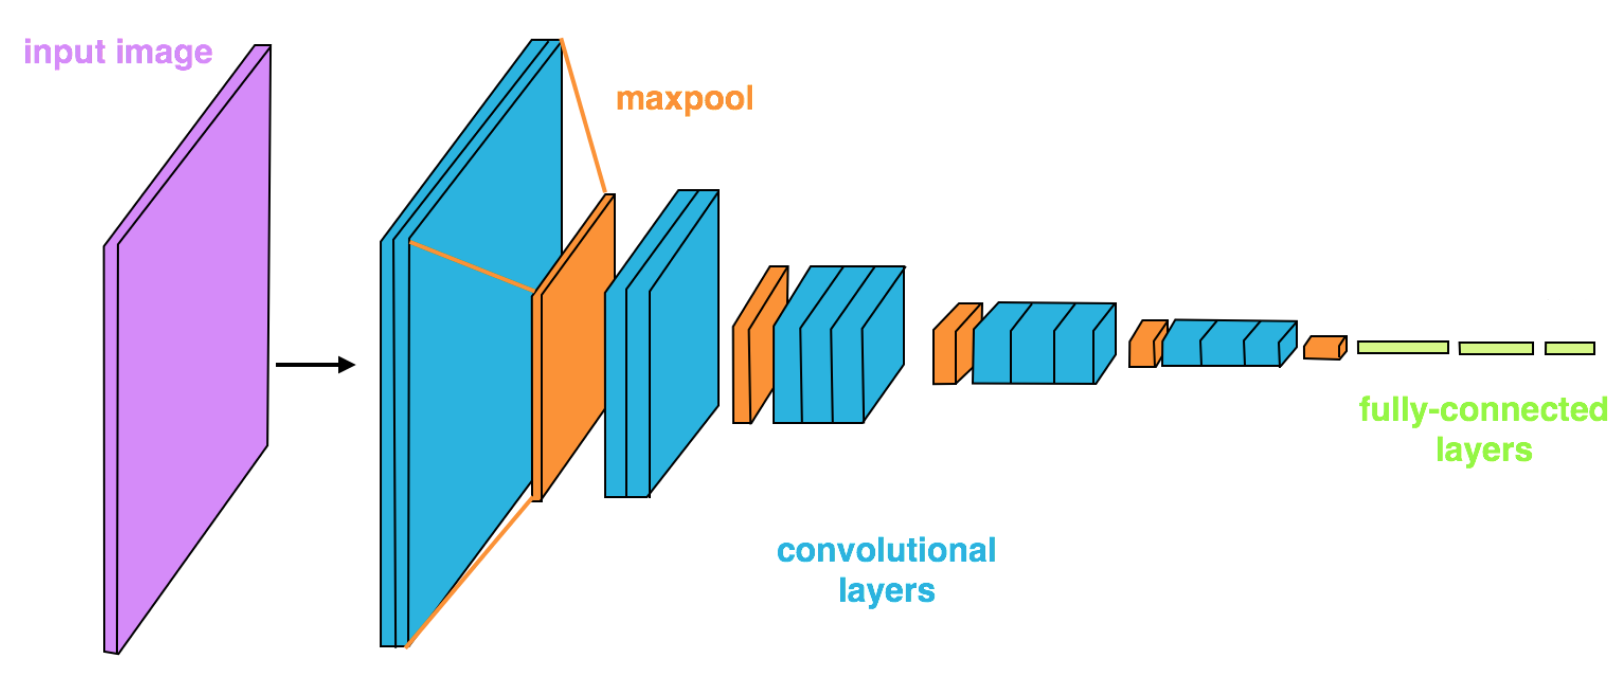

In [ ]:
# Loading Model Weights
model_weights = models.VGG16_Weights.DEFAULT

# Creating Mode Instance with only "features" part
vgg16 = models.vgg16(weights=model_weights).features.to(device)

# Info about our model
summary(vgg16,
        col_names=("num_params", "trainable"),
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Param #              Trainable
Sequential (Sequential)                  --                   True
├─Conv2d (0)                             1,792                True
├─ReLU (1)                               --                   --
├─Conv2d (2)                             36,928               True
├─ReLU (3)                               --                   --
├─MaxPool2d (4)                          --                   --
├─Conv2d (5)                             73,856               True
├─ReLU (6)                               --                   --
├─Conv2d (7)                             147,584              True
├─ReLU (8)                               --                   --
├─MaxPool2d (9)                          --                   --
├─Conv2d (10)                            295,168              True
├─ReLU (11)                              --                   --
├─Conv2d (12)                            590,080              True
├─Re

In [ ]:
# Freezing all the parametes of the model
for params in vgg16.parameters():
  params.requires_grad = False

summary(vgg16,
        col_names=("num_params", "trainable"),
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Param #              Trainable
Sequential (Sequential)                  --                   False
├─Conv2d (0)                             (1,792)              False
├─ReLU (1)                               --                   --
├─Conv2d (2)                             (36,928)             False
├─ReLU (3)                               --                   --
├─MaxPool2d (4)                          --                   --
├─Conv2d (5)                             (73,856)             False
├─ReLU (6)                               --                   --
├─Conv2d (7)                             (147,584)            False
├─ReLU (8)                               --                   --
├─MaxPool2d (9)                          --                   --
├─Conv2d (10)                            (295,168)            False
├─ReLU (11)                              --                   --
├─Conv2d (12)                            (590,080)            Fal

##Visualizing and Transform Images

In [ ]:
# Helper function to transform image to VGG accepable form
def image_transform(image):
  ''' Transforms the image into an acceptable form for VGG. '''

  data_transform = transforms.Compose([
      transforms.Resize(512),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

  image = data_transform(image).unsqueeze(dim=0) # Adding extra batch dimension

  return image

In [ ]:
# Helper function to un-normalize the input image for visualization
def convert_image(image):
  ''' Convert the image to a suitable form for displaying. '''

  image = image.cpu().detach().numpy()
  image = image.squeeze(0)
  image = image.transpose(1, 2, 0) # Convert image from [C, H, W] to [H, W, C]
  image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406]) # Un-normalizing image
  image = np.clip(image, 0., 1.)

  return image

In [ ]:
# Loading both Content and Style images as PIL object
style_image = Image.open(image_path / "style.jpg")
content_image = Image.open(image_path / "content.jpg")

# Transforming Content and Style images
style_image = image_transform(style_image).to(device)
content_image = image_transform(content_image).to(device)

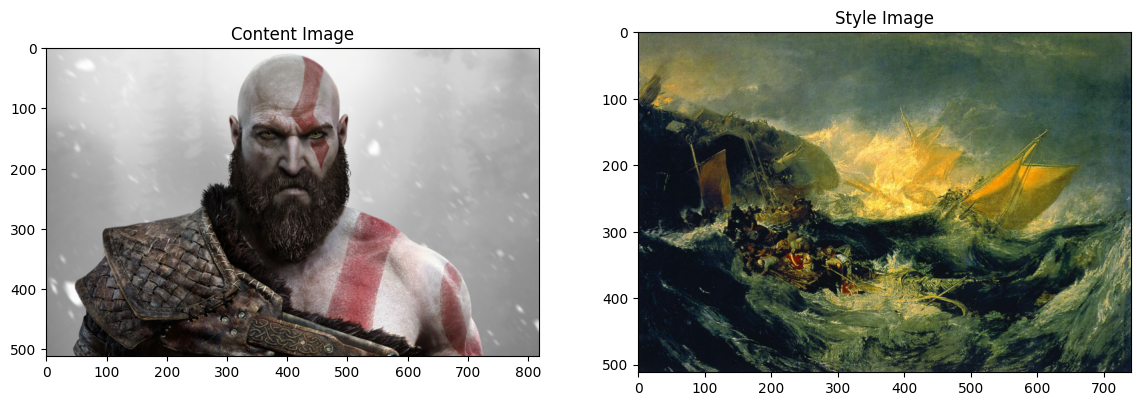

In [ ]:
# Display the content and style images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
ax1.set_title(f"Content Image")
ax1.imshow(convert_image(content_image))
ax2.set_title(f"Style Image")
ax2.imshow(convert_image(style_image))

##Content and Style Feature Maps
Content and style feature maps are two important components in neural style transfer, where the content feature maps aim to preserve the underlying content of an image, while the style feature maps are used to transfer the artistic style of a reference image onto the content image.

In [ ]:
def get_feature_maps(image, model):
  '''
  Passes the image through model and saves all
  Feature Maps from Conv layers.
  '''
  feature_maps = {}
  conv_layer_index = 0

  for layer_num, layer in model._modules.items():
    image = layer(image) # Forward pass on the image

    if "Conv2d" in str(layer):
      conv_layer_index += 1
      feature_maps[f"conv_{conv_layer_index}"] = image # Save the layer name with its feature map

  return feature_maps

##Gram Matrix
A Gram matrix is a matrix that represents the correlations between the different channels in a feature map, and is commonly used to capture the style of an image. The Gram matrix of a convolutional layer can be calculated as follows:

1.   Flatten the feature map: Convert the 3D tensor (height, width, channels) of the feature map to a 2D tensor (height x width, channels) by reshaping it.
2.   Transpose the flattened feature map: Transpose the flattened tensor, which swaps the height x width and channels dimensions.
3.   Multiply the flattened feature map with its transpose: Calculate the dot product of the flattened tensor with its transpose, which results in a Gram matrix.

The resulting Gram matrix is a measure of the correlations between the different channels in the feature map. It can be used to represent the style of an image


In [ ]:
def gram_matrix(tensor):
  ''' Calculate the Gram Matrix of a given tensor '''

  # Get the dimensions of the input tensor
  batch_size, channels, height, width = tensor.shape

  # Reshape so we're multiplying the features for each channel
  tensor = tensor.reshape(channels, height * width)

  #Calculate the gram matrix
  gram = torch.mm(tensor, tensor.T)

  return gram

dict_keys(['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_6', 'conv_7', 'conv_8', 'conv_9', 'conv_10', 'conv_11', 'conv_12', 'conv_13'])


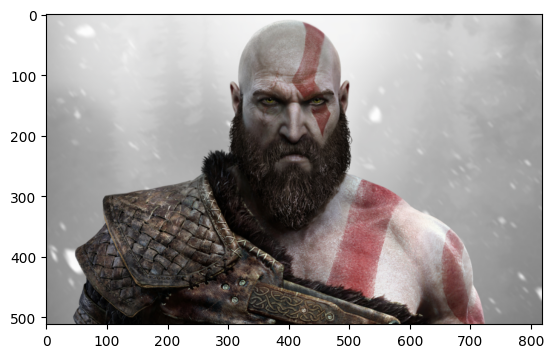

In [ ]:
# Get content and style features only once before training
content_features = get_feature_maps(content_image, vgg16)
style_features = get_feature_maps(style_image, vgg16)

print(content_features.keys())
#style_grams = [gram_matrix(feature) for feature in style_features.values()]

# Create target image and prep it for change
# target_image = torch.rand_like(content_image, requires_grad=True).to(device)
target_image = content_image.clone().detach().requires_grad_(True).to(device)
plt.imshow(convert_image(target_image))

##Weights and Loss
The style layer weights determine the degree of influence each style layer has on the final stylized image, with higher weights indicating more emphasis on that layer. We have the option to assign different weights to the style representation of each relevant layer. It is recommended to use a scale from 0 to 1 to assign these weights.



In [ ]:
# Content layers to be used
content_layers = ['conv_4']

# Weights for each style layer
style_weights = {'conv_1': 1.,
                 'conv_3': 0.75,
                 'conv_5': 0.2,
                 'conv_8': 0.2,
                 'conv_11': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

##Calculating Loss and Updating Target Image


*   Content Loss - The content loss is the difference between the feature maps of the content image and target image, measured as the mean squared error (MSE) at one or more layers of a pre-trained convolutional neural network (CNN).
*   Style Loss - The style loss is the difference between the Gram matrices of the style image and the target image, it is also measured as the mean squared error (MSE) at one or more layers of a pre-trained convolutional neural network (CNN).
*   Total Loss - The total loss is the sum of the content and style losses, weighted by alpha and beta respectively, which control the relative importance of the two losses in the final image.




Total Loss: 563105.6875


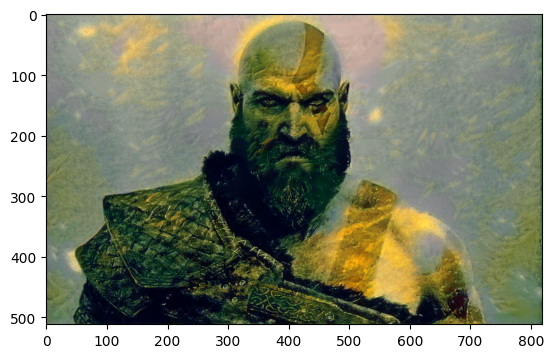

Total Loss: 232491.46875


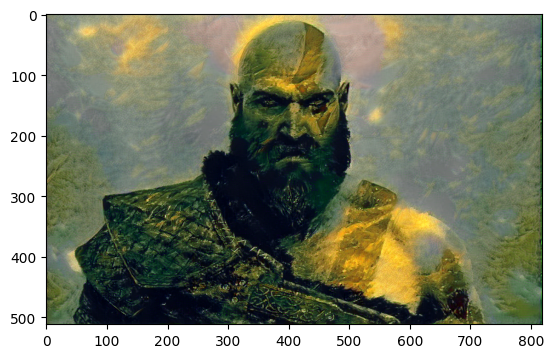

Total Loss: 124007.2578125


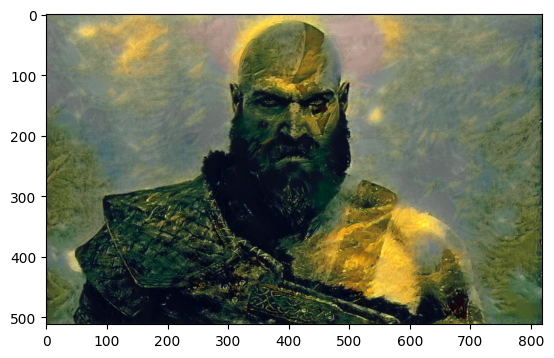

Total Loss: 75456.9453125


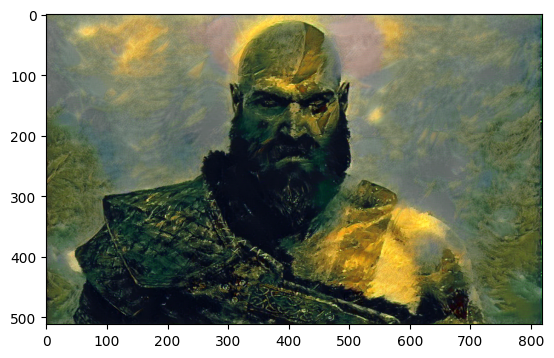

Total Loss: 58393.6015625


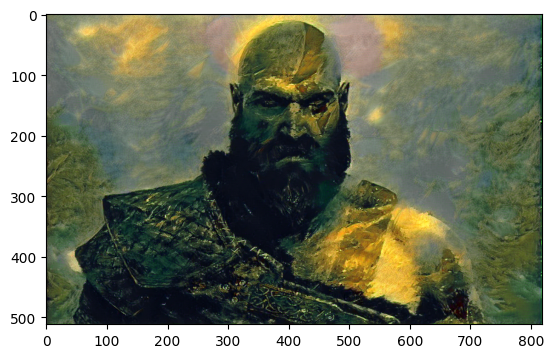

Total Loss: 46258.61328125


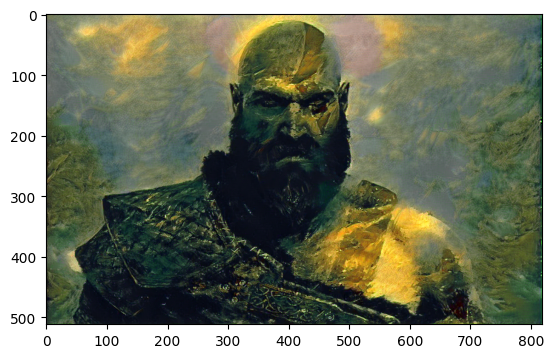

Total Loss: 35237.58203125


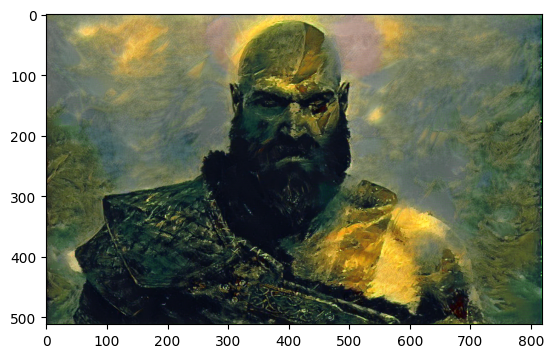

Total Loss: 35831.24609375


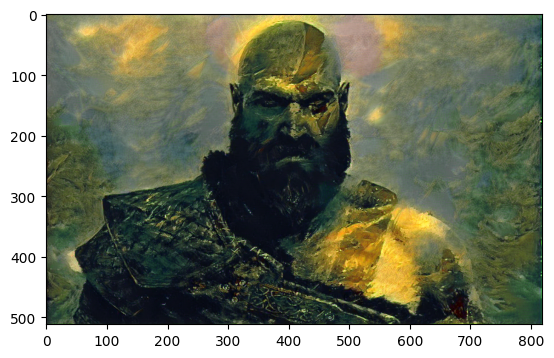

Total Loss: 31129.4609375


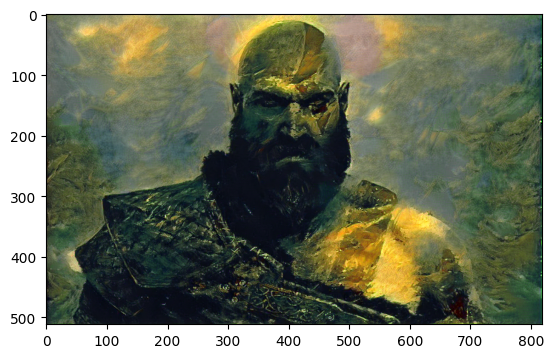

Total Loss: 31917.873046875


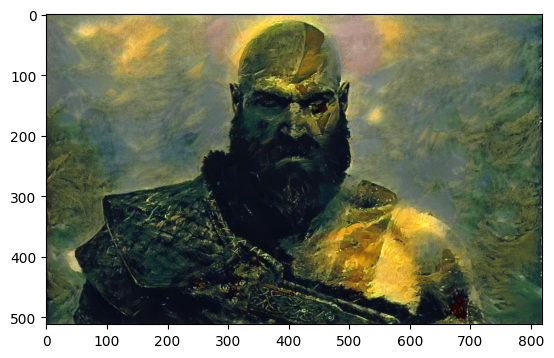

In [ ]:
# Adam optimizer to optimize traget image
optimizer = torch.optim.Adam([target_image], lr=0.01)
epochs = 5000

for epoch in range(epochs):

  # Get the features from your target image
  target_features = get_feature_maps(target_image, vgg16)

  content_loss = 0
  style_loss = 0

  for layer in content_layers:
    # Calculate Content Loss
    content_loss += torch.mean((target_features[layer] - content_features[layer]) ** 2)

  for layer in style_weights.keys():
    # Get the Target and Style gram matrices
    target_gram = gram_matrix(target_features[layer])
    style_gram = gram_matrix(style_features[layer])
    batch_size, channels, height, width = target_features[layer].shape

    # Style Loss for one layer
    layer_style_loss = torch.mean((target_gram - style_gram) ** 2) * style_weights[layer]
    # Add to the style loss
    style_loss += layer_style_loss / ((channels * height * width))

  # Calculate the total loss
  total_loss = content_weight * content_loss + style_weight * style_loss

  # Update the target image
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  # Display the progress
  if (epoch + 1) % 500 == 0:
    print(f"Total Loss: {total_loss.item()}")
    plt.imshow(convert_image(target_image))
    plt.show()

##Final Target Image

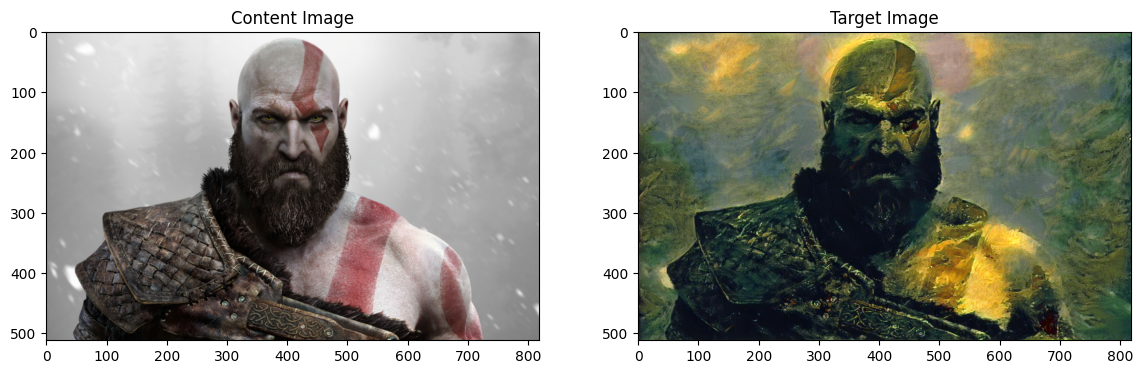

In [ ]:
# Display content and final target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
ax1.set_title(f"Content Image")
ax1.imshow(convert_image(content_image))
ax2.set_title(f"Target Image")
ax2.imshow(convert_image(target_image))